**Clustering of shapes**

*Question:*

Write a documented and commented python script, that is capable of the following:

- Generate N randomly placed objects in an image of dimensions (1000, 2000)

            - each object shall be either a rectangle or a circle

            - there shall be the same amount of objects of each shape

- Cluster the N objects into M clusters according to the following criteria:

            - center distance

            - circumference

In [81]:
# import all the required modules

import cv2
import numpy as np
import random
import math
from PIL import Image
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial import distance as ssd
plt.rcParams['figure.figsize'] = [20, 10]

In [82]:
# input arguments for the script

# N - no. of objects
N = 10

# M - no. of clusters
M = 2

# image size
width = 2000
height = 1000

# object dimensions
max_radius = 30
min_radius = 15

In [83]:
# check if input arguments are valid

assert N%M == 0, "Number of objects (N) should be divisible by the number of cluters (M) since equal no. of objects are expected in the each cluster"


In [84]:
# generate a blank image
input_image = np.zeros((height, width, 3), dtype=np.uint8)
print(input_image.shape)

(1000, 2000, 3)


In [85]:
# some utility functions

def euclidean_distance(x1, y1, x2, y2):
    """ Calculates distance between two points """
    return math.hypot((x1 - x2), (y1 - y2))

def split_list(a_list):
    """ Splits a list into two equal lists """
    half = len(a_list)//2
    return a_list[:half], a_list[half:]

def random_n_colors(n):
  """ generates N random RGB colors for plotting """
  ret = [] 
  for i in range(n): 
    r = int(random.random() * 256) 
    g = int(random.random() * 256) 
    b = int(random.random() * 256) 
    ret.append((r,g,b))  
  return ret

In [86]:
""" Iteratively generate N non-colliding object centers in the image
based on the max_radius and min_radius. Objects will be of different sizes. 
"""
centers_list = []
while len(centers_list) < N:
    r = random.randint(min_radius, max_radius)
    x = random.randint(max_radius, width - max_radius)
    y = random.randint(max_radius, height - max_radius)
    collide = False
    for x2, y2, r2 in centers_list:
        d = euclidean_distance(x, y, x2, y2)
        if d < r + r2:
            collide = True
            break
    if not collide:
        centers_list.append((x, y, r))

print(centers_list)

[(439, 793, 16), (1265, 247, 30), (1121, 886, 27), (525, 900, 18), (326, 534, 16), (1199, 591, 22), (1791, 722, 30), (251, 888, 15), (215, 555, 23), (30, 453, 22)]


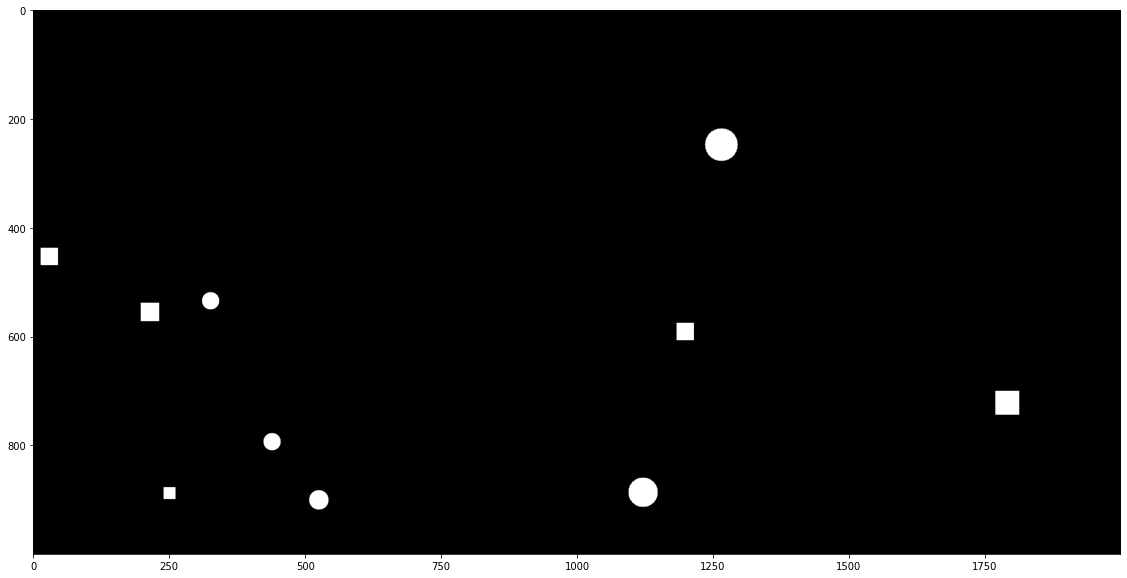

In [87]:
# split centers into two equal lists. It will represnt circle and rectangular objects
circle_list, rectangle_list = split_list(centers_list)

# Draw the objects in the blank image
for type, centers in [("circle", circle_list), ("rectangle", rectangle_list)]:
    for x, y, r in centers:
        center_coordinates = (int(x), int(y))
        # Line thickness of 2 px
        thickness = 2

        # white color
        color = (255, 255, 255)
        if type == "circle":
            input_image = cv2.circle(input_image, center_coordinates, r, color, -1)
        elif type == "rectangle":
            x1 = int(center_coordinates[0] - r/(1*(math.sqrt(2))))
            y1 = int(center_coordinates[1] - r/(1*(math.sqrt(2))))
            x2 = int(center_coordinates[0] + r/(1*(math.sqrt(2))))
            y2 = int(center_coordinates[1] + r/(1*(math.sqrt(2))))
            input_image = cv2.rectangle(input_image, (x1, y1), (x2, y2), color, -1)
imgplot = plt.imshow(input_image)
plt.show()

Image shape: (1000, 2000, 3)


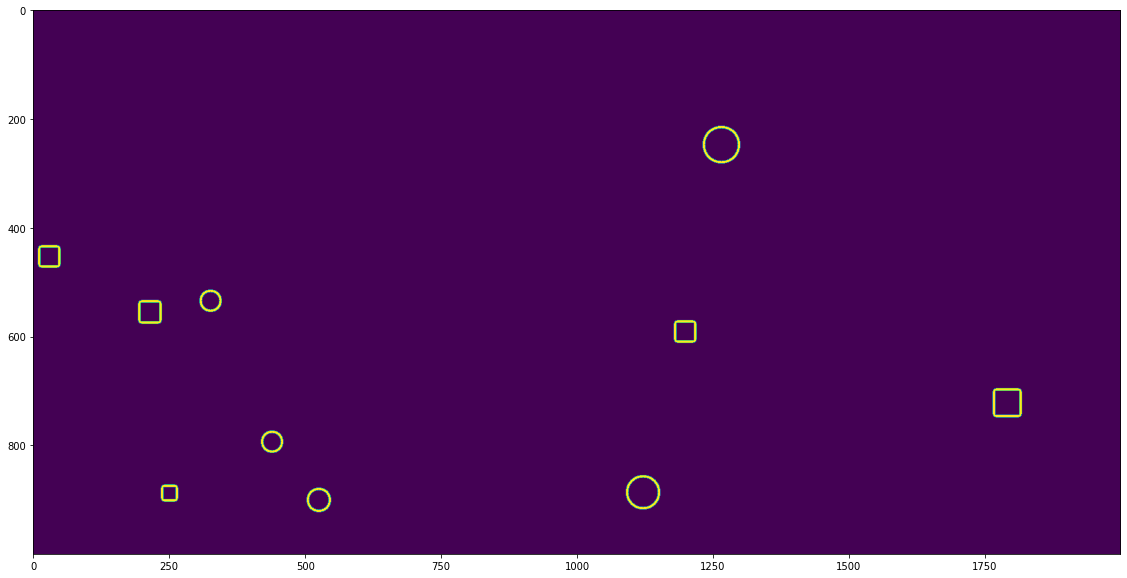

In [88]:
# copy image for future purpose
img = input_image.copy()
print("Image shape: " + str(img.shape)) 

# convert to grayscale
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply adaptive threshold
thresh = cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
imgplot = plt.imshow(thresh)
plt.show()

In [89]:
# Find all contours of binary image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Number of contours
num_contours=len(contours)


# Fill up all the shapes
filled=cv2.fillPoly(thresh, pts=contours, color=(255,255,255))


object_list = []
contour_crop=[]
colour_crop=[]

for cnt in contours:
    # Crop contours separately
    x,y,w,h = cv2.boundingRect(cnt)
    contour_crop.append(filled[y:y+h, x:x+w])
    colour_crop.append(img[y:y+h, x:x+w])

    # find object centers
    Moment = cv2.moments(cnt)
    cX = int(Moment["m10"] / Moment["m00"])
    cY = int(Moment["m01"] / Moment["m00"])
    object_list.append((cX, cY))

# Total number of contours
print("Total number of detected contours: " + str(len(contours)))

Total number of detected contours: 10


**Find clusters based on center distance**

We will use k-means to cluster the objects based on center distance

In [90]:
centers = np.asarray(object_list)
print(centers.shape)

# convert to np.float32
centers = np.float32(centers)

# define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,labels,center=cv2.kmeans(centers,M,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
print(labels)


(10, 2)
[[0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]]


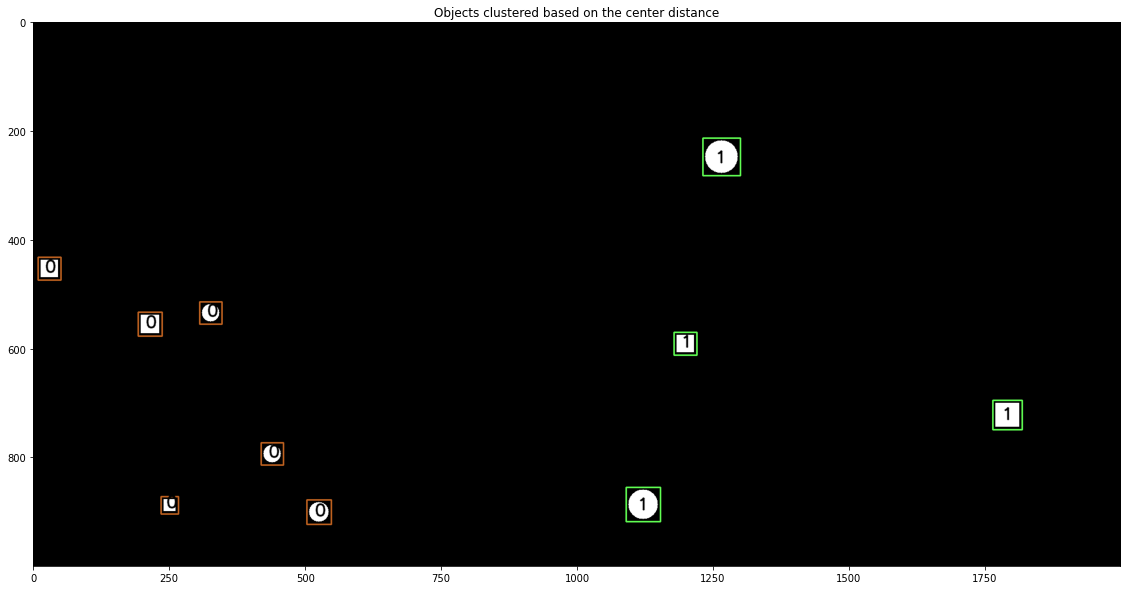

In [91]:
# randomly generate M colors for plotting
colors = random_n_colors(M)

# Draw contour clusters
dist_img = input_image.copy()
c = 0
for cnt in contours:

    # draw bounding box for the contour with unique color for each class
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(dist_img,(x,y),(x+w,y+h),colors[int(labels[c])],2)

    # find center of each contour
    Moment = cv2.moments(cnt)
    cX = int(Moment["m10"] / Moment["m00"])
    cY = int(Moment["m01"] / Moment["m00"])

    # write the class label on the object
    thickness = 2
    font = cv2.FONT_HERSHEY_SIMPLEX
    dist_img = cv2.putText(dist_img, str(int(labels[c])), (cX-int(w/6), cY+int(h/6)), font, 
                    1, (0, 0, 0), thickness, cv2.LINE_AA)
    c=c+1

dist_img = Image.fromarray(dist_img, 'RGB')
dist_img.save('1.png')
plt.title("Objects clustered based on the center distance")
plt.imshow(dist_img)
plt.show()


**Cluster based on circumference (shape)**

We will be using Hu-moments to find similarities between object shapes
and then cluster them based on the that

In [92]:
# Initialize similarity matrix
sim_mat=np.zeros((num_contours, num_contours))

# Compute similarity matrix [Uses Hu-Moments]
print("Similarity Matrix - Hu Moements")
for i in range(0,num_contours):
   for j in range(0, num_contours):
      im1=np.array(contour_crop[i])
      im2=np.array(contour_crop[j])
      sim_mat[i][j]=cv2.matchShapes(im1,im2,cv2.CONTOURS_MATCH_I2,0)
      print(str(round(sim_mat[i][j],4))+",",end =" ")
   print("\n")

'''
 Cluster the contours using similarity matrix and max cluster no.
 Returns cluster vector  [Range: 0 - (num_classes-1)]
'''
Zd = linkage(ssd.squareform(sim_mat), method="complete") 
cluster = fcluster(Zd, M, criterion='maxclust') - 1  
print("Cluster:-\n" + str(cluster))

Similarity Matrix - Hu Moements
0.0, 0.008, 0.0, 0.0, 0.0144, 0.0117, 0.0123, 0.0, 0.0117, 0.0, 

0.008, 0.0, 0.008, 0.008, 0.0064, 0.0037, 0.0043, 0.008, 0.0037, 0.008, 

0.0, 0.008, 0.0, 0.0, 0.0144, 0.0117, 0.0123, 0.0, 0.0117, 0.0, 

0.0, 0.008, 0.0, 0.0, 0.0144, 0.0117, 0.0123, 0.0, 0.0117, 0.0, 

0.0144, 0.0064, 0.0144, 0.0144, 0.0, 0.0026, 0.0021, 0.0144, 0.0026, 0.0144, 

0.0117, 0.0037, 0.0117, 0.0117, 0.0026, 0.0, 0.0005, 0.0117, 0.0, 0.0117, 

0.0123, 0.0043, 0.0123, 0.0123, 0.0021, 0.0005, 0.0, 0.0123, 0.0005, 0.0123, 

0.0, 0.008, 0.0, 0.0, 0.0144, 0.0117, 0.0123, 0.0, 0.0117, 0.0, 

0.0117, 0.0037, 0.0117, 0.0117, 0.0026, 0.0, 0.0005, 0.0117, 0.0, 0.0117, 

0.0, 0.008, 0.0, 0.0, 0.0144, 0.0117, 0.0123, 0.0, 0.0117, 0.0, 

Cluster:-
[0 1 0 0 1 1 1 0 1 0]


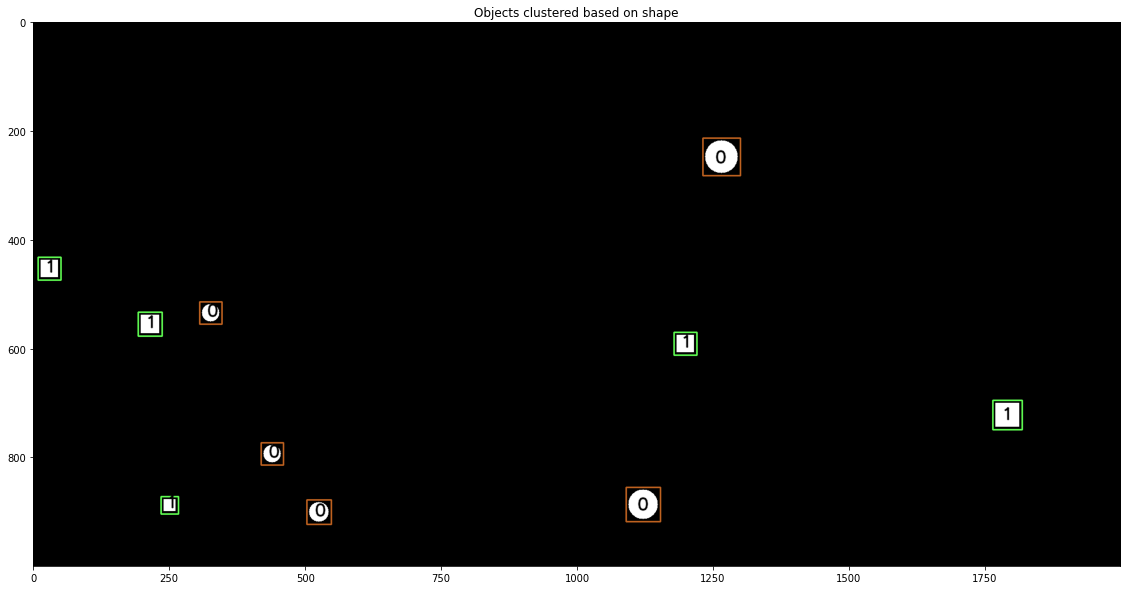

In [93]:
# Draw contour clusters
shape_img = input_image.copy()
c=0
for cnt in contours:
    # find center of each contour
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(shape_img,(x,y),(x+w,y+h),colors[int(cluster[c])],2)

    # write the class label on the object
    Moment = cv2.moments(cnt)
    cX = int(Moment["m10"] / Moment["m00"])
    cY = int(Moment["m01"] / Moment["m00"])
    thickness = 2
    font = cv2.FONT_HERSHEY_SIMPLEX
    shape_img = cv2.putText(shape_img, str(int(cluster[c])), (cX-int(w/6), cY+int(h/6)), font, 
                    1, (0, 0, 0), thickness, cv2.LINE_AA)
    c=c+1 

shape_img = Image.fromarray(shape_img, 'RGB')
shape_img.save('1.png')
plt.title("Objects clustered based on shape")
plt.imshow(shape_img)
plt.show()